# Analyzing Plato's Dialogues with Topic Modeling
## Iris Wu (iw5hte@virginia.edu) DS 5001 Spring 2023

## End goal of this notebook:
- Produce a table of document and topic concentrations.
- Produce a table of topics and term counts, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.
- Explore the data.

### Setting up necessary tools:
Importing useful packages -

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import plotly.express as px
import warnings
from hac import HAC
from graphviz import Graph
from scipy.spatial.distance import pdist
warnings.filterwarnings('ignore')

Setting up configurations (for data and functions):

In [2]:
data_in = 'data/output'
data_out = 'data/output'
data_prefix = 'plato'

In [3]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 20
max_iter = 5
n_top_terms = 9

OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

weight_thresh = 0.2
corr_thresh = .1
nmi_thresh = .25

BAG = PARA

TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

A function to make a topic model -

In [4]:
def make_topic_model(bag, phi_theta):
    
    count_engine_f = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
    count_model_f = count_engine_f.fit_transform(doc.doc_str)
    term = count_engine_f.get_feature_names_out()
    voc = pd.DataFrame(index=term)
    voc.index.name = 'term_str'
    dtm_f = pd.DataFrame(count_model_f.toarray(), index=doc.index, columns=term)
    lda_engine_f = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
    lda_model_f = lda_engine_f.fit_transform(count_model_f)
    theta_f = pd.DataFrame(lda_model_f, index=doc.index)
    if phi_theta == 'theta':
        theta_f.columns.name = 'topic_id'
        theta_f.columns = TNAMES
        return theta_f
    elif phi_theta == 'phi':
        phi_f = pd.DataFrame(lda_engine_f.components_, columns=term, index=TNAMES)
        phi_f.index.name = 'topic_id'
        phi_f.columns.name  = 'term_str'
        return phi_f

### Organizing Data

Getting the LIB and TOKEN tables -

In [5]:
LIB = pd.read_csv(f"{data_in}/{data_prefix}-LIB.csv").set_index(BOOK)
LIB

source_file_path       raw_title  \
book_id                                                   
1497       data/THE_REPUBLIC-pg1497.txt    THE REPUBLIC   
1571            data/CRITIAS-pg1571.txt         CRITIAS   
1572            data/TIMAEUS-pg1572.txt         TIMAEUS   
1579              data/LYSIS-pg1579.txt           LYSIS   
1580          data/CHARMIDES-pg1580.txt       CHARMIDES   
1584             data/LACHES-pg1584.txt          LACHES   
1591         data/PROTAGORAS-pg1591.txt      PROTAGORAS   
1598         data/EUTHYDEMUS-pg1598.txt      EUTHYDEMUS   
1600          data/SYMPOSIUM-pg1600.txt       SYMPOSIUM   
1616           data/CRATYLUS-pg1616.txt        CRATYLUS   
1635                data/ION-pg1635.txt             ION   
1636           data/PHAEDRUS-pg1636.txt        PHAEDRUS   
1642          data/EUTHYPHRO-pg1642.txt       EUTHYPHRO   
1643               data/MENO-pg1643.txt            MENO   
1656            data/APOLOGY-pg1656.txt         APOLOGY   
1657              data/CRITO-pg1657.txt           CRITO   
1658             data/PHAEDO-pg1658.txt          PHAEDO   
1672            data/GORGIAS-pg1672.txt         GORGIAS   
1673     data/LESSER_HIPPIAS-pg1673.txt  LESSER HIPPIAS   
1676       data/ALCIBIADES_I-pg1676.txt    ALCIBIADES I   
1677      data/ALCIBIADES_II-pg1677.txt   ALCIBIADES II   
1681            data/ERYXIAS-pg1681.txt         ERYXIAS   
1682          data/MENEXENUS-pg1682.txt       MENEXENUS   
1687         data/PARMENIDES-pg1687.txt      PARMENIDES   
1726         data/THEAETETUS-pg1726.txt      THEAETETUS   
1735            data/SOPHIST-pg1735.txt         SOPHIST   
1738          data/STATESMAN-pg1738.txt       STATESMAN   
1744           data/PHILEBUS-pg1744.txt        PHILEBUS   
1750               data/LAWS-pg1750.txt            LAWS   

                         chap_regex  book_len  n_chaps  
book_id                                                 
1497     ^\s*BOOK\s+[IVXLCM]+\.\s*$    118489       10  
1571       PERSONS OF THE DIALOGUE:      6789        1  
1572               ^Section\s+\d+.$     69903        8  
1579       PERSONS OF THE DIALOGUE:      9188        1  
1580       PERSONS OF THE DIALOGUE:     10750        1  
1584       PERSONS OF THE DIALOGUE:     10286        1  
1591       PERSONS OF THE DIALOGUE:     22995        1  
1598       PERSONS OF THE DIALOGUE:     15882        1  
1600       PERSONS OF THE DIALOGUE:     22248        1  
1616       PERSONS OF THE DIALOGUE:     23932        1  
1635       PERSONS OF THE DIALOGUE:      5177        1  
1636       PERSONS OF THE DIALOGUE:     23209        1  
1642       PERSONS OF THE DIALOGUE:      6793        1  
1643       PERSONS OF THE DIALOGUE:     12847        1  
1656                        APOLOGY     11404        1  
1657       PERSONS OF THE DIALOGUE:      5386        1  
1658       PERSONS OF THE DIALOGUE:     27512        1  
1672       PERSONS OF THE DIALOGUE:     35829        1  
1673       PERSONS OF THE DIALOGUE:      6048        1  
1676       PERSONS OF THE DIALOGUE:     14810        1  
1677       PERSONS OF THE DIALOGUE:      5529        1  
1681       PERSONS OF THE DIALOGUE:      6417        1  
1682       PERSONS OF THE DIALOGUE:      6581        1  
1687       PERSONS OF THE DIALOGUE:     18974        1  
1726       PERSONS OF THE DIALOGUE:     31453        1  
1735       PERSONS OF THE DIALOGUE:     22229        1  
1738       PERSONS OF THE DIALOGUE:     23615        1  
1744       PERSONS OF THE DIALOGUE:     23398        1  
1750     ^\s*BOOK\s+[IVXLCM]+\.\s*$    141128       12

In [6]:
TOKEN = pd.read_csv(f'{data_in}/{data_prefix}-CORPUS.csv')
TOKEN

book_id  chap_id  para_num  sent_num  token_num            pos_tuple  \
0          1497        1         1         0          0         ('I', 'PRP')   
1          1497        1         1         0          1      ('went', 'VBD')   
2          1497        1         1         0          2       ('down', 'RB')   
3          1497        1         1         0          3  ('yesterday', 'NN')   
4          1497        1         1         0          4         ('to', 'TO')   
...         ...      ...       ...       ...        ...                  ...   
738796     1750       12       127         0          5     ('EBook', 'NNP')   
738797     1750       12       127         0          6         ('of', 'IN')   
738798     1750       12       127         0          7     ('Laws,', 'NNP')   
738799     1750       12       127         0          8         ('by', 'IN')   
738800     1750       12       127         0          9     ('Plato', 'NNP')   

        pos  token_str   term_str pos_group  
0       PRP          I          i        PR  
1       VBD       went       went        VB  
2        RB       down       down        RB  
3        NN  yesterday  yesterday        NN  
4        TO         to         to        TO  
...     ...        ...        ...       ...  
738796  NNP      EBook      ebook        NN  
738797   IN         of         of        IN  
738798  NNP      Laws,       laws        NN  
738799   IN         by         by        IN  
738800  NNP      Plato      plato        NN  

[738801 rows x 10 columns]

Getting nouns into document -

In [7]:
doc = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

### Utilizing the topic model
Producing a phi table (how much a topic prefers a word)

In [8]:
PHI = make_topic_model(BAG, 'phi')
PHI

term_str    ability     abode    abroad    absence   absolute   abstain  \
topic_id                                                                  
T00        3.067582  1.050000  0.050000   0.050000   0.050000  0.050000   
T01        0.050000  2.621213  0.050000   0.050000   0.050000  0.050000   
T02        0.050000  0.478787  0.050000   0.050000   0.680104  0.050000   
T03        0.050000  0.050000  0.050000  19.623237   0.050000  0.050000   
T04        1.128892  1.050000  0.050000   0.050129   0.802170  0.050000   
T05        0.050000  0.050000  0.050000   0.050000  26.427406  0.050000   
T06        0.051280  0.050000  0.050000   0.050000   7.735793  0.050000   
T07        0.050000  0.050000  1.050000   0.050000   0.050000  1.427480   
T08        1.473625  0.050000  0.050000   0.050000   0.050000  0.050000   
T09        0.050000  0.050000  0.050004   0.050000   0.050000  0.050000   
T10        0.050000  0.050000  3.049996   5.225495   0.564898  0.050000   
T11        0.050000  0.050000  1.050000   0.050000   0.487915  0.050000   
T12        1.511067  0.050000  0.050000   0.050000   0.050000  1.899522   
T13        0.050000  0.050000  0.050000   1.768512   1.118877  0.050000   
T14        1.113534  0.050000  0.050000   0.051869   0.050000  0.050000   
T15        1.317919  0.050000  0.050000   0.050000   0.152833  0.050000   
T16       12.464875  0.050000  0.050000   0.272227   3.815558  2.888506   
T17        0.242118  0.050000  0.050000   2.358586   3.714445  1.712335   
T18        0.129108  2.050000  0.050000   3.049878   0.050000  0.322157   
T19        0.050000  0.050000  0.050000   0.050067   0.050000  0.050000   

term_str  abstract  abstraction  absurdity  abundance  ...  yielding  \
topic_id                                               ...             
T00       0.050000     0.050000   1.596216   0.050000  ...  0.050000   
T01       0.050000     0.050000   0.985254   0.050000  ...  0.050000   
T02       0.050000     0.758003   0.050000  12.628905  ...  0.050000   
T03       0.050000     0.050000   0.050000   0.050000  ...  0.050000   
T04       0.483106     0.050000   0.050000   0.050000  ...  0.050000   
T05       0.050000     0.050000   0.050000   1.159803  ...  0.378363   
T06       4.508969     4.269029   1.704943   0.050000  ...  0.050000   
T07       0.050000     0.050000   1.070378   0.302775  ...  0.050000   
T08       0.050000     0.050000   0.050000   0.050000  ...  0.050000   
T09       0.053907     1.122969   0.050000   0.050000  ...  0.050000   
T10       4.106318     0.050000   0.050000   0.050000  ...  0.050000   
T11       0.050000     1.050000   0.050000   0.050000  ...  0.050000   
T12       0.050000     0.050000   0.050000   0.050000  ...  0.050000   
T13       2.885384     0.050000   9.848663   0.050000  ...  0.050000   
T14       0.050000     0.050000   1.740922   0.050000  ...  0.050000   
T15       0.050000     0.050000   0.050000   0.050000  ...  3.721637   
T16       0.050000     0.050000   0.050000   0.050000  ...  1.050000   
T17       0.259220     0.050000   0.050000   0.050000  ...  0.050000   
T18       0.053096     0.050000   0.050000   3.108517  ...  0.050000   
T19       0.050000     0.050000   0.403625   0.050000  ...  0.050000   

term_str      yoke      young    younger      youth  youth upwards    youths  \
topic_id                                                                       
T00       0.050000   0.050000   0.560981   8.784357       0.050000  0.050000   
T01       0.050000   0.050000   0.050023   0.052189       0.050000  1.605051   
T02       0.378205   0.050000   0.050000   4.711487       0.050000  0.050000   
T03       0.050000   1.316894   0.050000   5.009028       0.050000  0.401596   
T04       0.050000   1.269254   0.050000  16.719087       0.050000  0.050000   
T05       0.050000   0.050000   0.050000   0.050000       0.050000  0.260396   
T06       0.050002   0.050000   1.099966  12.787403       0.050000  0.664797   
T07       0.050000  17.383688   0.050000   8

Getting a table with entry and probability -

In [9]:
ww_sums = PHI.sum(axis=1)
total = ww_sums.sum()
ww_sums = ww_sums/total
vector = pd.DataFrame(ww_sums, columns=['p'])
vector['log_mle'] = np.log2(vector.p)
vector['mle_entropy'] = vector['p'] * -1 * vector['log_mle']
vector

p   log_mle  mle_entropy
topic_id                                 
T00       0.028558 -5.129983     0.146500
T01       0.032828 -4.928937     0.161806
T02       0.058542 -4.094395     0.239692
T03       0.038092 -4.714355     0.179581
T04       0.046442 -4.428415     0.205666
T05       0.044223 -4.499050     0.198963
T06       0.081845 -3.610962     0.295539
T07       0.044950 -4.475522     0.201177
T08       0.038783 -4.688430     0.181832
T09       0.048899 -4.354040     0.212910
T10       0.053103 -4.235075     0.224893
T11       0.039194 -4.673216     0.183163
T12       0.077568 -3.688401     0.286101
T13       0.041944 -4.575385     0.191911
T14       0.045777 -4.449244     0.203672
T15       0.027043 -5.208613     0.140855
T16       0.084257 -3.569056     0.300719
T17       0.069118 -3.854793     0.266436
T18       0.046245 -4.434569     0.205075
T19       0.052589 -4.249091     0.223456

In [10]:
vector_label = vector.sort_values('mle_entropy', ascending=False).reset_index()
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
vector_label = vector_label.join(TOPICS['label'], on='topic_id')
vector_label

topic_id         p   log_mle  mle_entropy  \
0       T16  0.084257 -3.569056     0.300719   
1       T06  0.081845 -3.610962     0.295539   
2       T12  0.077568 -3.688401     0.286101   
3       T17  0.069118 -3.854793     0.266436   
4       T02  0.058542 -4.094395     0.239692   
5       T10  0.053103 -4.235075     0.224893   
6       T19  0.052589 -4.249091     0.223456   
7       T09  0.048899 -4.354040     0.212910   
8       T04  0.046442 -4.428415     0.205666   
9       T18  0.046245 -4.434569     0.205075   
10      T14  0.045777 -4.449244     0.203672   
11      T07  0.044950 -4.475522     0.201177   
12      T05  0.044223 -4.499050     0.198963   
13      T13  0.041944 -4.575385     0.191911   
14      T11  0.039194 -4.673216     0.183163   
15      T08  0.038783 -4.688430     0.181832   
16      T03  0.038092 -4.714355     0.179581   
17      T01  0.032828 -4.928937     0.161806   
18      T00  0.028558 -5.129983     0.146500   
19      T15  0.027043 -5.208613     0.140855   

                                                label  
0   T16 justice, men, course, man, soul, gods, thi...  
1   T06 opinion, motion, nature, world, things, so...  
2   T12 yes, law, life, man, men, argument, way, d...  
3   T17 men, city, number, man, women, time, citiz...  
4   T02 earth, way, water, things, air, body, natu...  
5   T10 words, men, education, music, impossible, ...  
6   T19 time, son, thing, father, man, people, way...  
7   T09 knowledge, virtue, courage, man, rest, nat...  
8   T04 pleasure, pain, truth, point, friend, plac...  
9   T18 soul, body, care, manner, man, soul body, ...  
10  T14 names, stranger, things, air, legislator, ...  
11  T07 laws, nature, state, rulers, law, class, g...  
12  T05 things, theaetetus, idea, class, form, opi...  
13  T13 question, man, answer, harmony, words, nat...  
14  T11 art, good, arts, medicine, sort, thing, he...  
15  T08 certainly, body, man, state, case, soul, m...  
16  T03 wisdom, evil, science, man, good, temperan...  
17  T01 reason, wise, means, man, desires, soul, b...  
18  T00 true, socrates, knowledge, pleasures, part...  
19  T15 power, government, end, clearly, things, u...

What are the words that constitute each topic?

In [11]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
TOPICS

term_str          0           1          2          3           4           5  \
topic_id                                                                        
T00            true    socrates  knowledge  pleasures       parts   inference   
T01          reason        wise      means        man     desires        soul   
T02           earth         way      water     things         air        body   
T03          wisdom        evil    science        man        good  temperance   
T04        pleasure        pain      truth      point      friend       place   
T05          things  theaetetus       idea      class        form     opinion   
T06         opinion      motion     nature      world      things        soul   
T07            laws      nature      state     rulers         law       class   
T08       certainly        body        man      state        case        soul   
T09       knowledge      virtue    courage        man        rest      nature   
T10           words         men  education      music  impossible        mind   
T11             art        good       arts   medicine        sort       thing   
T12             yes         law       life        man         men    argument   
T13        question         man     answer    harmony       words      nature   
T14           names    stranger     things        air  legislator         man   
T15           power  government        end    clearly      things         use   
T16         justice         men     course        man        soul        gods   
T17             men        city     number        man       women        time   
T18            soul        body       care     manner         man   soul body   
T19            time         son      thing     father         man      people   

term_str           6              7           8  
topic_id                                         
T00             kind          pains       times  
T01             best           sort         art  
T02           nature        animals       parts  
T03        ignorance            law      friend  
T04             sort  pleasure pain       doubt  
T05       definition          thing       names  
T06             word           mind   existence  
T07        guardians            art        city  
T08           matter           said       power  
T09            thing            sun   principle  
T10              man            way         law  
T11           health        science    question  
T12              way          death    children  
T13       difference       argument         men  
T14             gold           land  generation  
T15             body           form      virtue  
T16           things      injustice        love  
T17         citizens          years       state  
T18         opposite          blood     disease  
T19              way            men      desire

Producing a theta table (how much a document prefers a topic)

In [12]:
THETA = make_topic_model(BAG, 'theta')
THETA

T00       T01       T02       T03       T04  \
book_id chap_id para_num                                                     
1497    1       1         0.002174  0.002174  0.002174  0.002174  0.002174   
                2         0.016667  0.349999  0.350001  0.016667  0.016667   
                3         0.025000  0.025000  0.025000  0.025000  0.025000   
                4         0.012500  0.012500  0.012500  0.012500  0.012500   
                5         0.010000  0.010000  0.010000  0.010000  0.010000   
...                            ...       ...       ...       ...       ...   
1750    12      120       0.525000  0.025000  0.025000  0.025000  0.025000   
                121       0.001064  0.001064  0.001064  0.001064  0.001064   
                122       0.007143  0.007143  0.007143  0.007143  0.007143   
                123       0.050000  0.050000  0.050000  0.050000  0.050000   
                127       0.025000  0.025000  0.025000  0.025000  0.025000   

                               T05       T06       T07       T08       T09  \
book_id chap_id para_num                                                     
1497    1       1         0.002174  0.002174  0.002174  0.106816  0.002174   
                2         0.016667  0.016667  0.016667  0.016667  0.016667   
                3         0.025000  0.025000  0.025000  0.025000  0.025000   
                4         0.012500  0.012500  0.012500  0.012500  0.012500   
                5         0.010000  0.010000  0.010000  0.010000  0.010000   
...                            ...       ...       ...       ...       ...   
1750    12      120       0.025000  0.025000  0.025000  0.025000  0.025000   
                121       0.001064  0.162115  0.001064  0.001064  0.001064   
                122       0.007143  0.007143  0.007143  0.007143  0.007143   
                123       0.050000  0.050000  0.050000  0.050000  0.050000   
                127       0.025000  0.025000  0.025000  0.025000  0.025000   

                               T10       T11       T12       T13       T14  \
book_id chap_id para_num                                                     
1497    1       1         0.002174  0.002174  0.002174  0.002174  0.002174   
                2         0.016667  0.016667  0.016667  0.016667  0.016667   
                3         0.025000  0.025000  0.025000  0.025000  0.025000   
                4         0.012500  0.012500  0.012500  0.012500  0.012500   
                5         0.010000  0.010000  0.010000  0.010000  0.010000   
...                            ...       ...       ...       ...       ...   
1750    12      120       0.025000  0.025000  0.025000  0.025000  0.025000   
                121       0.663417  0.001064  0.001064  0.057582  0.001064   
                122       0.007143  0.007143  0.007143  0.007143  0.007143   
                123       0.050000  0.050000  0.050000  0.050000  0.050000   
                127       0.025000  0.025000  0.025000  0.025000  0.025000   

                               T15       T16       T17       T18       T19  
book_id chap_id para_num                                                    
1497    1       1         0.002174  0.227571  0.002174  0.002174  0.628657  
                2         0.016667  0.016667  0.016667  0.016667  0.016667  
                3         0.025000  0.025000  0.025000  0.025000  0.525000  
                4         0.012500  0.012500  0.012500  0.012500  0.762500  
                5         0.010000  0.010000  0.515801  0.010000  0.304199  
...                            ...       ...       ...       ...       ...  
1750    12      120       0.025000  0.025000  0.025000  0.025000  0.025000  
                121       0.001064  0.001064  0.099865  0.001064  0.001064  
                122       0.007143  0.007143  0.194216  0.677212  0.007143  
                123       0.050000  0.050000  0.050000  0.050000  0.050000  
                127       0.525000  0.025000  0.025000  0.0250

### Quantifying and visualizing topic weight

In [13]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS

term_str          0           1          2          3           4           5  \
topic_id                                                                        
T00            true    socrates  knowledge  pleasures       parts   inference   
T01          reason        wise      means        man     desires        soul   
T02           earth         way      water     things         air        body   
T03          wisdom        evil    science        man        good  temperance   
T04        pleasure        pain      truth      point      friend       place   
T05          things  theaetetus       idea      class        form     opinion   
T06         opinion      motion     nature      world      things        soul   
T07            laws      nature      state     rulers         law       class   
T08       certainly        body        man      state        case        soul   
T09       knowledge      virtue    courage        man        rest      nature   
T10           words         men  education      music  impossible        mind   
T11             art        good       arts   medicine        sort       thing   
T12             yes         law       life        man         men    argument   
T13        question         man     answer    harmony       words      nature   
T14           names    stranger     things        air  legislator         man   
T15           power  government        end    clearly      things         use   
T16         justice         men     course        man        soul        gods   
T17             men        city     number        man       women        time   
T18            soul        body       care     manner         man   soul body   
T19            time         son      thing     father         man      people   

term_str           6              7           8  doc_weight_sum  \
topic_id                                                          
T00             kind          pains       times      969.119800   
T01             best           sort         art      746.572917   
T02           nature        animals       parts      636.698236   
T03        ignorance            law      friend      693.383679   
T04             sort  pleasure pain       doubt      889.388336   
T05       definition          thing       names     1000.874156   
T06             word           mind   existence      922.172034   
T07        guardians            art        city      692.431142   
T08           matter           said       power      827.318100   
T09            thing            sun   principle      768.254544   
T10              man            way         law      683.587284   
T11           health        science    question      820.467654   
T12              way          death    children      997.541293   
T13       difference       argument         men      852.611298   
T14             gold           land  generation      594.307557   
T15             body           form      virtue      678.491858   
T16           things      injustice        love      899.728559   
T17         citizens          years       state      753.785258   
T18         opposite          blood     disease      638.739707   
T19              way            men      desire      862.526590   

term_str                                              label  term_freq  
topic_id                                                                
T00       T00 true, socrates, knowledge, pleasures, part...   0.028558  
T01       T01 reason, wise, means, man, desires, soul, b...   0.032828  
T02       T02 earth, way, water, things, air, body, natu...   0.058542  
T03       T03 wisdom, evil, science, man, good, temperan...   0.038092  
T04       T04 pleasure, pain, truth, point, friend, plac...   0.046442  
T05       T05 things, theaetetus, idea, class, form, opi...   0.044223  
T06       T06 opinion, motion, nature, world, things, so...   0.081845  
T07       T07 laws, nature, state, rulers, law, class, g...   0.044950  
T08       T0

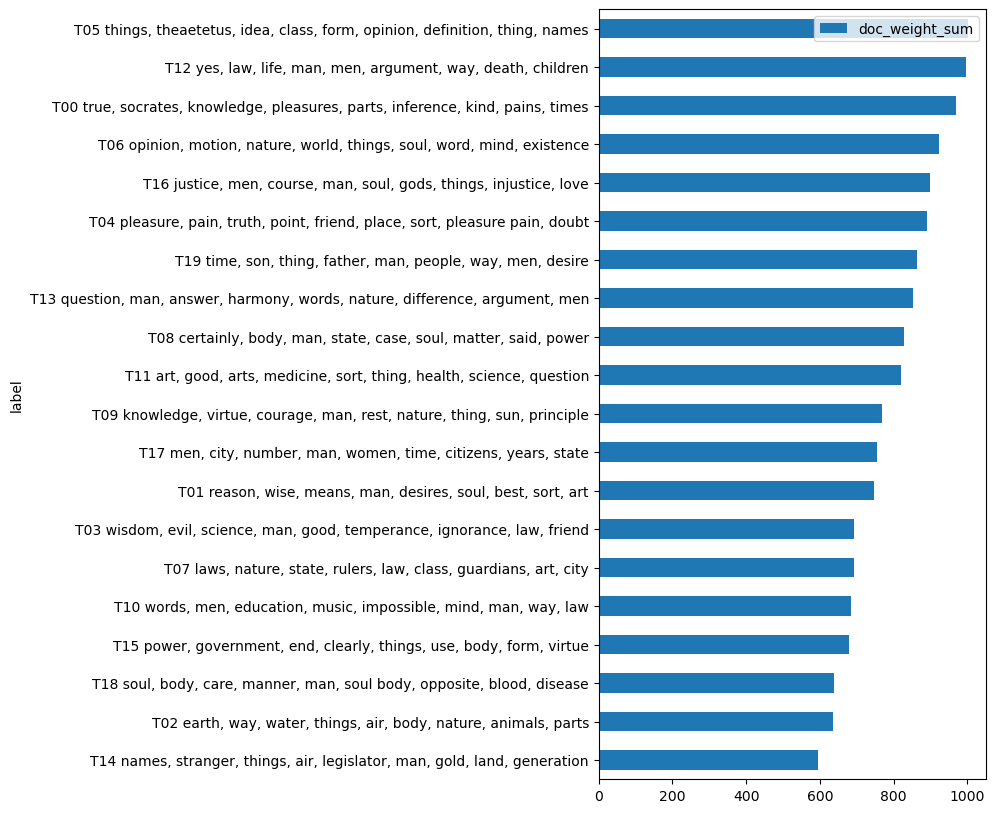

In [14]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

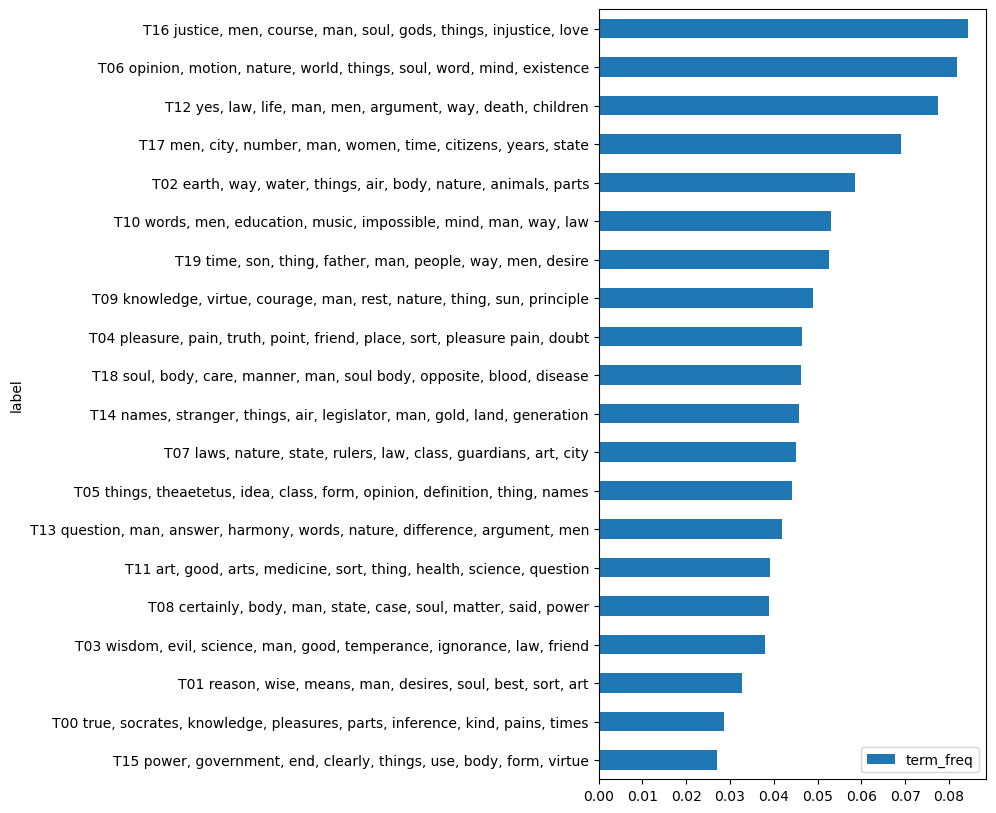

In [15]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

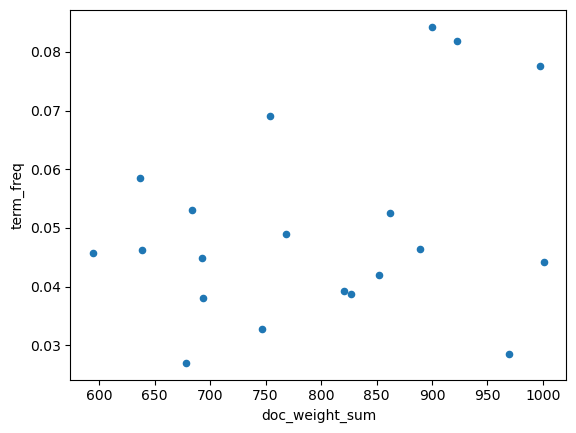

In [16]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

### Relating texts to topics
Adding information about the topics and the dialogues: which topics are most associated with The Republic, for instance?

In [17]:
TITLES = sorted(LIB.raw_title.value_counts().index.to_list())
TOPICS[TITLES] = THETA.join(LIB, on='book_id').groupby('raw_title')[TNAMES].mean().T
TOPICS.sort_values('THE REPUBLIC', ascending=False)

term_str          0           1          2          3           4           5  \
topic_id                                                                        
T12             yes         law       life        man         men    argument   
T16         justice         men     course        man        soul        gods   
T08       certainly        body        man      state        case        soul   
T00            true    socrates  knowledge  pleasures       parts   inference   
T04        pleasure        pain      truth      point      friend       place   
T01          reason        wise      means        man     desires        soul   
T17             men        city     number        man       women        time   
T19            time         son      thing     father         man      people   
T07            laws      nature      state     rulers         law       class   
T13        question         man     answer    harmony       words      nature   
T05          things  theaetetus       idea      class        form     opinion   
T15           power  government        end    clearly      things         use   
T09       knowledge      virtue    courage        man        rest      nature   
T06         opinion      motion     nature      world      things        soul   
T10           words         men  education      music  impossible        mind   
T11             art        good       arts   medicine        sort       thing   
T03          wisdom        evil    science        man        good  temperance   
T18            soul        body       care     manner         man   soul body   
T02           earth         way      water     things         air        body   
T14           names    stranger     things        air  legislator         man   

term_str           6              7           8  doc_weight_sum  ...  \
topic_id                                                         ...   
T12              way          death    children      997.541293  ...   
T16           things      injustice        love      899.728559  ...   
T08           matter           said       power      827.318100  ...   
T00             kind          pains       times      969.119800  ...   
T04             sort  pleasure pain       doubt      889.388336  ...   
T01             best           sort         art      746.572917  ...   
T17         citizens          years       state      753.785258  ...   
T19              way            men      desire      862.526590  ...   
T07        guardians            art        city      692.431142  ...   
T13       difference       argument         men      852.611298  ...   
T05       definition          thing       names     1000.874156  ...   
T15             body           form      virtue      678.491858  ...   
T09            thing            sun   principle      768.254544  ...   
T06             word           mind   existence      922.172034  ...   
T10              man            way         law      683.587284  ...   
T11           health        science    question      820.467654  ...   
T03        ignorance            law      friend      693.383679  ...   
T18         opposite          blood     disease      638.739707  ...   
T02           nature        animals       parts      636.698236  ...   
T14             gold           land  generation      594.307557  ...   

term_str    PHAEDO  PHAEDRUS  PHILEBUS  PROTAGORAS   SOPHIST  STATESMAN  \
topic_id                                                                  
T12       0.081612  0.035332  0.033701    0.064625  0.032883   0.037103   
T16       0.083013  0.081447  0.043759    0.047167  0.048962   0.030201   
T08       0.054046  0.069027  0.038122    0.052069  0.038796   0.040322   
T00       0.048908  0.066587  0.099029    0.039182  0.061007   0.054331   
T04       0.046817  0.055722  0.118252    0.062417  0.053957   0.048638   
T01       0.042900  0.050229  0.037636    0.050309  0.040029   0.045074   
T17       0.042226  0.051692  0.

Which dialogue is most associated with a particular topic?

In [18]:
book_means = THETA.groupby(['book_id']).mean()
book_means.sort_values('T10', ascending = False)['T10']

book_id
1635    0.115485
1682    0.079737
1656    0.072452
1750    0.064774
1673    0.062429
1600    0.056311
1591    0.050072
1636    0.050010
1657    0.048317
1598    0.047912
1579    0.046593
1676    0.045447
1497    0.043725
1572    0.041901
1687    0.040639
1677    0.039380
1584    0.037888
1672    0.037558
1643    0.035937
1726    0.035329
1735    0.033397
1658    0.033031
1616    0.032189
1738    0.030951
1744    0.030169
1642    0.029365
1681    0.026534
1580    0.023436
1571    0.015249
Name: T10, dtype: float64

Assigning the most probable dialogue to each topic -

In [19]:
TOPICS['title'] = TOPICS[TITLES].idxmax(1)
TOPICS.iloc[:,n_top_terms:].sort_values(['title','doc_weight_sum'], ascending=[True,False])
TOPICS

term_str          0           1          2          3           4           5  \
topic_id                                                                        
T00            true    socrates  knowledge  pleasures       parts   inference   
T01          reason        wise      means        man     desires        soul   
T02           earth         way      water     things         air        body   
T03          wisdom        evil    science        man        good  temperance   
T04        pleasure        pain      truth      point      friend       place   
T05          things  theaetetus       idea      class        form     opinion   
T06         opinion      motion     nature      world      things        soul   
T07            laws      nature      state     rulers         law       class   
T08       certainly        body        man      state        case        soul   
T09       knowledge      virtue    courage        man        rest      nature   
T10           words         men  education      music  impossible        mind   
T11             art        good       arts   medicine        sort       thing   
T12             yes         law       life        man         men    argument   
T13        question         man     answer    harmony       words      nature   
T14           names    stranger     things        air  legislator         man   
T15           power  government        end    clearly      things         use   
T16         justice         men     course        man        soul        gods   
T17             men        city     number        man       women        time   
T18            soul        body       care     manner         man   soul body   
T19            time         son      thing     father         man      people   

term_str           6              7           8  doc_weight_sum  ...  \
topic_id                                                         ...   
T00             kind          pains       times      969.119800  ...   
T01             best           sort         art      746.572917  ...   
T02           nature        animals       parts      636.698236  ...   
T03        ignorance            law      friend      693.383679  ...   
T04             sort  pleasure pain       doubt      889.388336  ...   
T05       definition          thing       names     1000.874156  ...   
T06             word           mind   existence      922.172034  ...   
T07        guardians            art        city      692.431142  ...   
T08           matter           said       power      827.318100  ...   
T09            thing            sun   principle      768.254544  ...   
T10              man            way         law      683.587284  ...   
T11           health        science    question      820.467654  ...   
T12              way          death    children      997.541293  ...   
T13       difference       argument         men      852.611298  ...   
T14             gold           land  generation      594.307557  ...   
T15             body           form      virtue      678.491858  ...   
T16           things      injustice        love      899.728559  ...   
T17         citizens          years       state      753.785258  ...   
T18         opposite          blood     disease      638.739707  ...   
T19              way            men      desire      862.526590  ...   

term_str  PHAEDRUS  PHILEBUS  PROTAGORAS   SOPHIST  STATESMAN  SYMPOSIUM  \
topic_id                                                                   
T00       0.066587  0.099029    0.039182  0.061007   0.054331   0.045941   
T01       0.050229  0.037636    0.050309  0.040029   0.045074   0.065721   
T02       0.045202  0.045062    0.028895  0.038637   0.054327   0.047301   
T03       0.028361  0.055806    0.069747  0.031939   0.063924   0.043304   
T04       0.055722  0.118252    0.062417  0.053957   0.048638   0.052243   
T05       0.047162  0.092420    0.058392  0.116503   0.059336   0.023880   
T06       0.068883  0.05

### Visualizing relationships between topics

<Figure size 640x480 with 0 Axes>

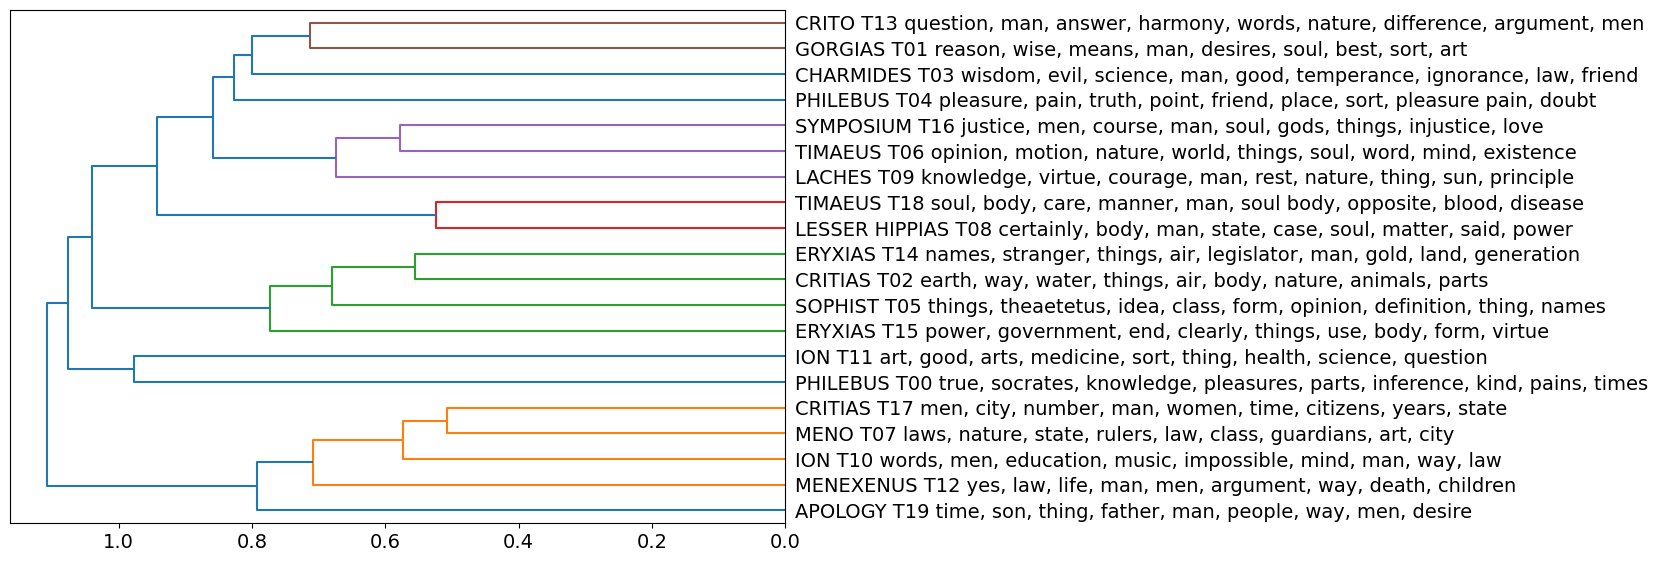

In [20]:
labels  = [f"{a.upper()} {b}" for a, b in zip(TOPICS.title, TOPICS.label)]
HAC(PHI, labels=labels).plot();

<Figure size 640x480 with 0 Axes>

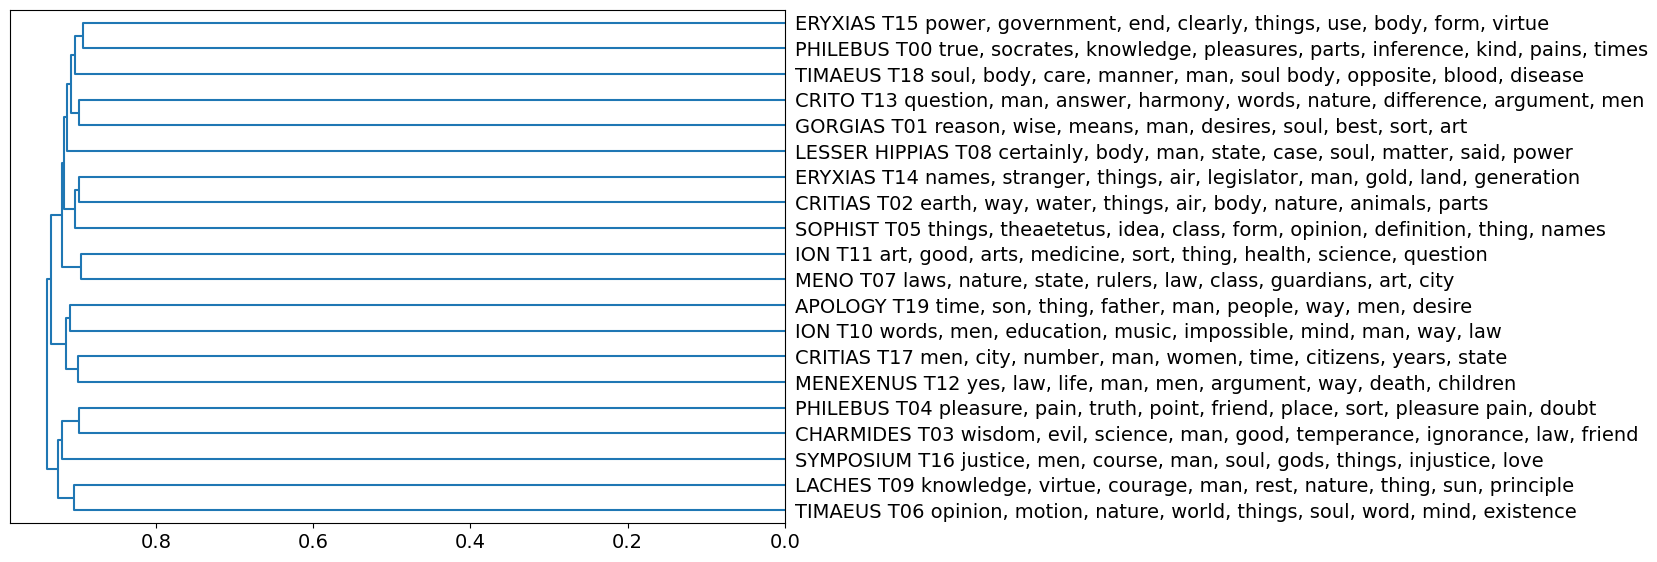

In [21]:
HAC(THETA.T, labels=labels).plot();

Running PCA on the topics -

<Figure size 640x480 with 0 Axes>

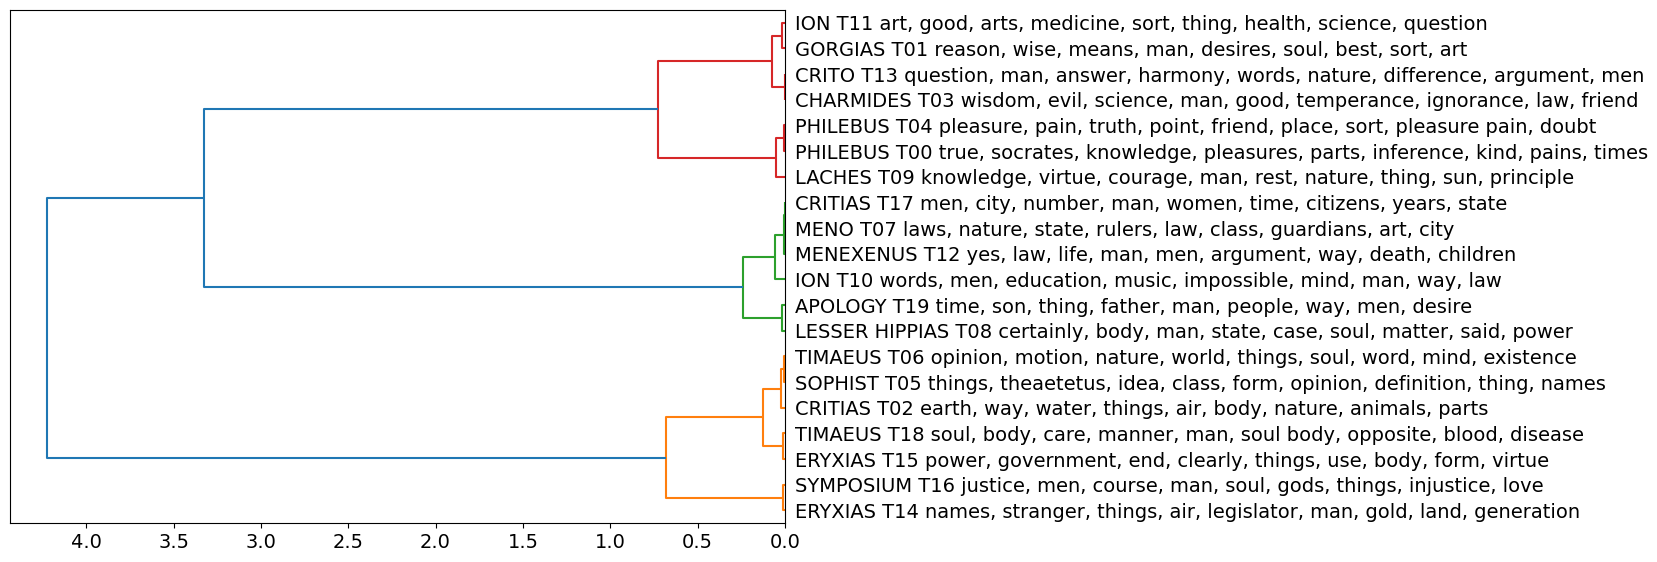

In [22]:
pca_engine_phi = PCA(2)
PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
HAC(PHI_COMPS, labels=labels).plot()

<Figure size 640x480 with 0 Axes>

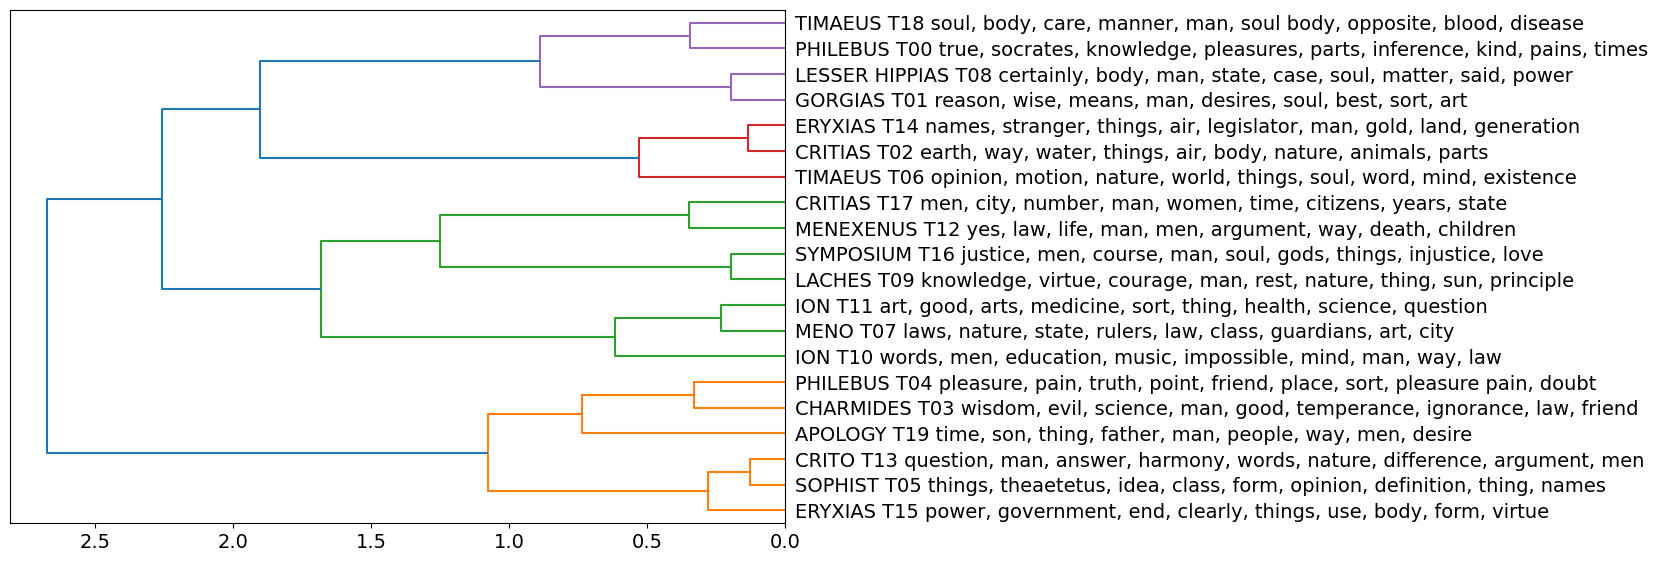

In [23]:
pca_engine_theta = PCA(5)
THETA_COMPS = pd.DataFrame(pca_engine_theta.fit_transform(normalize(THETA.T.values, norm='l2', axis=1)), index=THETA.T.index)
THETA_COMPS.index.name = 'topic_id'
HAC(THETA_COMPS, labels=labels).plot()

Examining how much the top two principal components contribute to the variance of each topic

In [54]:
px.scatter(THETA_COMPS.reset_index(), 1, 2, 
           size=TOPICS.doc_weight_sum, 
           color=TOPICS.title, 
           text='topic_id', 
           hover_name=TOPICS.label, 
           height=600, width=700)

In [47]:
px.scatter(PHI_COMPS.reset_index(), 0, 1, 
           size=TOPICS.term_freq, 
           color=TOPICS.title, 
           text='topic_id', hover_name=TOPICS.label, height=600, width=700)

In [26]:
PHI_LOADINGS = pd.DataFrame(pca_engine_phi.components_.T * np.sqrt(pca_engine_phi.explained_variance_), index=PHI.T.index)
PHI_LOADINGS.index.name = 'term_str'
px.scatter(PHI_LOADINGS.reset_index(), 0, 1, text='term_str', height=600, width=700)

In [27]:
THETA_LOADINGS = pd.DataFrame(pca_engine_theta.components_.T * np.sqrt(pca_engine_theta.explained_variance_), index=THETA.index)

In [28]:
doc['doc_label'] = doc.apply(lambda x: f"{LIB.loc[x.name[0]].raw_title}-{x.name[1]}", axis=1)
doc['book'] = doc.apply(lambda x: f"{LIB.loc[x.name[0]].raw_title}", axis=1)
doc['n_chars'] = doc.doc_str.str.len()

In [29]:
px.scatter(THETA_LOADINGS.reset_index(), 0, 1, 
           size=doc.n_chars,
           color=doc.book, height=600, width=900)

In [30]:
X = pd.concat([THETA.corr(method='kendall').stack().to_frame('corr_theta'), 
               PHI.T.corr(method='kendall').stack().to_frame('corr_phi')], axis=1)
X.index.names = ['topic_id_x','topic_id_y']
X = X.query("topic_id_x < topic_id_y") 
X['corr_mean'] = (X.corr_theta + X.corr_phi) / 2
X = X.reset_index()
X['label_x'] = X.topic_id_x.map(TOPICS.label)
X['label_y'] = X.topic_id_y.map(TOPICS.label)
X = X.set_index(['topic_id_x','topic_id_y'])
X

corr_theta  corr_phi  corr_mean  \
topic_id_x topic_id_y                                    
T00        T01           0.575439  0.203972   0.389705   
           T02           0.606126  0.142081   0.374103   
           T03           0.586150  0.202359   0.394254   
           T04           0.552859  0.203374   0.378116   
           T05           0.520164  0.178941   0.349553   
...                           ...       ...        ...   
T16        T18           0.600447  0.174356   0.387402   
           T19           0.551546  0.230682   0.391114   
T17        T18           0.626106  0.152830   0.389468   
           T19           0.589750  0.267260   0.428505   
T18        T19           0.592438  0.142742   0.367590   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T00        T01         T00 true, socrates, knowledge, pleasures, part...   
           T02         T00 true, socrates, knowledge, pleasures, part...   
           T03         T00 true, socrates, knowledge, pleasures, part...   
           T04         T00 true, socrates, knowledge, pleasures, part...   
           T05         T00 true, socrates, knowledge, pleasures, part...   
...                                                                  ...   
T16        T18         T16 justice, men, course, man, soul, gods, thi...   
           T19         T16 justice, men, course, man, soul, gods, thi...   
T17        T18         T17 men, city, number, man, women, time, citiz...   
           T19         T17 men, city, number, man, women, time, citiz...   
T18        T19         T18 soul, body, care, manner, man, soul body, ...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T00        T01         T01 reason, wise, means, man, desires, soul, b...  
           T02         T02 earth, way, water, things, air, body, natu...  
           T03         T03 wisdom, evil, science, man, good, temperan...  
           T04         T04 pleasure, pain, truth, point, friend, plac...  
           T05         T05 things, theaetetus, idea, class, form, opi...  
...                                                                  ...  
T16        T18         T18 soul, body, care, manner, man, soul body, ...  
           T19         T19 time, son, thing, father, man, people, way...  
T17        T18         T18 soul, body, care, manner, man, soul body, ...  
           T19         T19 time, son, thing, father, man, people, way...  
T18        T19         T19 time, son, thing, father, man, people, way...  

[190 rows x 5 columns]

### Examining correlations between the topics

In [31]:
px.scatter(X, 'corr_phi', 'corr_theta', hover_data=['label_x', 'label_y'], width=600, height=1000)

In [32]:
X.sort_values('corr_phi', ascending=False)[['corr_phi', 'label_x','label_y']]

corr_phi  \
topic_id_x topic_id_y             
T12        T17         0.326184   
           T19         0.272267   
T17        T19         0.267260   
T08        T12         0.258489   
T07        T17         0.257977   
...                         ...   
T05        T17         0.108581   
T02        T03         0.096554   
T06        T17         0.094899   
T05        T12         0.087047   
T06        T12         0.066666   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T12        T17         T12 yes, law, life, man, men, argument, way, d...   
           T19         T12 yes, law, life, man, men, argument, way, d...   
T17        T19         T17 men, city, number, man, women, time, citiz...   
T08        T12         T08 certainly, body, man, state, case, soul, m...   
T07        T17         T07 laws, nature, state, rulers, law, class, g...   
...                                                                  ...   
T05        T17         T05 things, theaetetus, idea, class, form, opi...   
T02        T03         T02 earth, way, water, things, air, body, natu...   
T06        T17         T06 opinion, motion, nature, world, things, so...   
T05        T12         T05 things, theaetetus, idea, class, form, opi...   
T06        T12         T06 opinion, motion, nature, world, things, so...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T12        T17         T17 men, city, number, man, women, time, citiz...  
           T19         T19 time, son, thing, father, man, people, way...  
T17        T19         T19 time, son, thing, father, man, people, way...  
T08        T12         T12 yes, law, life, man, men, argument, way, d...  
T07        T17         T17 men, city, number, man, women, time, citiz...  
...                                                                  ...  
T05        T17         T17 men, city, number, man, women, time, citiz...  
T02        T03         T03 wisdom, evil, science, man, good, temperan...  
T06        T17         T17 men, city, number, man, women, time, citiz...  
T05        T12         T12 yes, law, life, man, men, argument, way, d...  
T06        T12         T12 yes, law, life, man, men, argument, way, d...  

[190 rows x 3 columns]

In [33]:
X.sort_values('corr_phi', ascending=True)[['corr_phi', 'label_x','label_y']]

corr_phi  \
topic_id_x topic_id_y             
T06        T12         0.066666   
T05        T12         0.087047   
T06        T17         0.094899   
T02        T03         0.096554   
T05        T17         0.108581   
...                         ...   
T07        T17         0.257977   
T08        T12         0.258489   
T17        T19         0.267260   
T12        T19         0.272267   
           T17         0.326184   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T06        T12         T06 opinion, motion, nature, world, things, so...   
T05        T12         T05 things, theaetetus, idea, class, form, opi...   
T06        T17         T06 opinion, motion, nature, world, things, so...   
T02        T03         T02 earth, way, water, things, air, body, natu...   
T05        T17         T05 things, theaetetus, idea, class, form, opi...   
...                                                                  ...   
T07        T17         T07 laws, nature, state, rulers, law, class, g...   
T08        T12         T08 certainly, body, man, state, case, soul, m...   
T17        T19         T17 men, city, number, man, women, time, citiz...   
T12        T19         T12 yes, law, life, man, men, argument, way, d...   
           T17         T12 yes, law, life, man, men, argument, way, d...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T06        T12         T12 yes, law, life, man, men, argument, way, d...  
T05        T12         T12 yes, law, life, man, men, argument, way, d...  
T06        T17         T17 men, city, number, man, women, time, citiz...  
T02        T03         T03 wisdom, evil, science, man, good, temperan...  
T05        T17         T17 men, city, number, man, women, time, citiz...  
...                                                                  ...  
T07        T17         T17 men, city, number, man, women, time, citiz...  
T08        T12         T12 yes, law, life, man, men, argument, way, d...  
T17        T19         T19 time, son, thing, father, man, people, way...  
T12        T19         T19 time, son, thing, father, man, people, way...  
           T17         T17 men, city, number, man, women, time, citiz...  

[190 rows x 3 columns]

### Introducing gravity to the topics

In [34]:
dist_metric = 'cityblock'
# dist_metric = 'cosine'
# dist_metric = 'jensenshannon'
X['dist_theta'] = pdist(THETA.T, dist_metric)
X['dist_phi'] = pdist(PHI, dist_metric)

In [35]:
X = X.reset_index()
X['weight_x'] = X.topic_id_x.map(TOPICS.doc_weight_sum)
X['weight_y'] = X.topic_id_y.map(TOPICS.doc_weight_sum)
X['gravity'] = X.weight_x * X.weight_y / X.dist_theta**2
X = X.set_index(['topic_id_x','topic_id_y'])

In [36]:
px.scatter(X, 'dist_theta', 'dist_phi', title=dist_metric, size='gravity', width=500, height=500, hover_data=['label_x','label_y'])

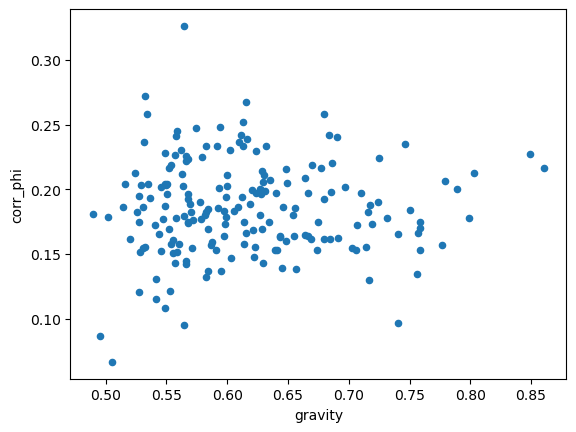

In [37]:
X.plot.scatter('gravity','corr_phi');

### Making graphs

In [38]:
TOPICS['short_label'] = TOPICS.label.apply(lambda x: x.split()[0] + r"\n" + " ".join(x.split(", ")[1:4]) + r"\n" + " ".join(x.split(", ")[4:8]) )

In [39]:
THETA2 = THETA[THETA >= weight_thresh].stack().to_frame('topic_weight').reset_index()

TOPICS['p'] = THETA2.topic_id.value_counts(normalize=True)

TPAIRS = THETA2.merge(THETA2, on=PARA).value_counts(['topic_id_x', 'topic_id_y']).to_frame('n').query("topic_id_x < topic_id_y")
TPAIRS = TPAIRS.sort_index().reset_index()

TPAIRS['p_xy'] = TPAIRS.n / TPAIRS.n.sum()
TPAIRS['p_x'] = TPAIRS.topic_id_x.map(TOPICS.p)
TPAIRS['p_y'] = TPAIRS.topic_id_y.map(TOPICS.p)
TPAIRS['p_yGx'] = TPAIRS.p_xy / TPAIRS.p_x
TPAIRS['p_xGy'] = TPAIRS.p_xy / TPAIRS.p_y
TPAIRS['pwmi'] = np.log2(TPAIRS.p_xy / (TPAIRS.p_x * TPAIRS.p_y))
TPAIRS['mi'] = TPAIRS.pwmi * TPAIRS.p_xy
TPAIRS['nmi'] = TPAIRS.pwmi / np.log2(1/TPAIRS.p_xy) # Normalized point-wise mutual information (Bouma 2009) https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf 

TPAIRS = TPAIRS.set_index(['topic_id_x', 'topic_id_y'])
TPAIRS = TPAIRS.join(X)

In [40]:
EDGES = []

# By correlation
EDGES.append(TPAIRS[TPAIRS.corr_phi > corr_thresh].index.to_list())

# By mutual information
EDGES.append(TPAIRS[TPAIRS.nmi > nmi_thresh].index.to_list())

# By both
EDGES.append(TPAIRS[(TPAIRS.corr_phi > corr_thresh) & (TPAIRS.nmi > nmi_thresh)].index.to_list())

In [41]:
px.scatter(TPAIRS.reset_index(), 'nmi', 'corr_phi', 
           hover_data=['label_x','label_y'],
           size='gravity', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

In [42]:
def draw_graph(edge_num = 0):
    G = Graph('tm', node_attr={'shape':'rectangle'})
    NODES = set()
    for src, dst in EDGES[edge_num]:
        NODES.add(src)
        NODES.add(dst)
        G.edge(src, dst)
    for node in sorted(NODES):
        G.node(node, TOPICS.loc[node].short_label)
    G.view(f"tm{edge_num}")

In [55]:
draw_graph(0)
draw_graph(1)
draw_graph(2)

### Outputting tables

In [44]:
doc.to_csv(f'{data_out}/{data_prefix}-DOCS-PARA.csv')
TOPICS.to_csv(f'{data_out}/{data_prefix}-TOPICS-PARA.csv')
PHI.to_csv(f'{data_out}/{data_prefix}-PHI-PARA.csv')
THETA.to_csv(f'{data_out}/{data_prefix}-THETA-PARA.csv')